In [55]:
import regex as reg 
import unicodedata  
import os, re, json, html, base64
import numpy as np
import pandas as pd
from pathlib import Path
from ftfy import fix_text
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [56]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw"
IMG_DIR  = DATA_DIR / "images" / "image_train"

X_train = pd.read_csv(DATA_DIR / "X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR / "Y_train_CVw08PX.csv", index_col=0)

In [57]:
df = X_train.join(Y_train, how="inner")

In [58]:
display(df.head())

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


In [59]:
IMG_DIR = Path("/workspace/data/images/image_train")
files = list(IMG_DIR.glob("*.jpg"))
pat = re.compile(r"image_(\d+)_product_(\d+)\.jpg$")
lookup = {}
for p in files:
    m = pat.search(p.name)
    if m:
        lookup[m.group(1)] = p

df["image_path"] = df["imageid"].apply(lambda i: lookup.get(str(int(i))))

S = 256
def img_cell(p, size=S):
    if p is None or not Path(p).exists():
        return ""
    b64 = base64.b64encode(Path(p).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" style="width:{size}px;height:{size}px;object-fit:contain;display:block;" />'

cols = ["prdtypecode","designation","description","imageid","image_path"]
view = df[cols].head(20).copy()
view["image"] = view["image_path"].apply(lambda p: img_cell(p, S))
view = view.drop(columns=["image_path"])

style = """
<style>
table { table-layout: fixed; width: 100%; }
th, td { text-align: left !important; vertical-align: top !important; }
td:nth-child(1){ width:90px; }
td:nth-child(2){ width:260px; }
td:nth-child(3){ width:520px; word-wrap: break-word; white-space: normal; }
td:nth-child(4){ width:150px; }
td:nth-child(5){ width:270px; }
</style>
"""

#display(HTML(style + view.to_html(escape=False, index=True)))

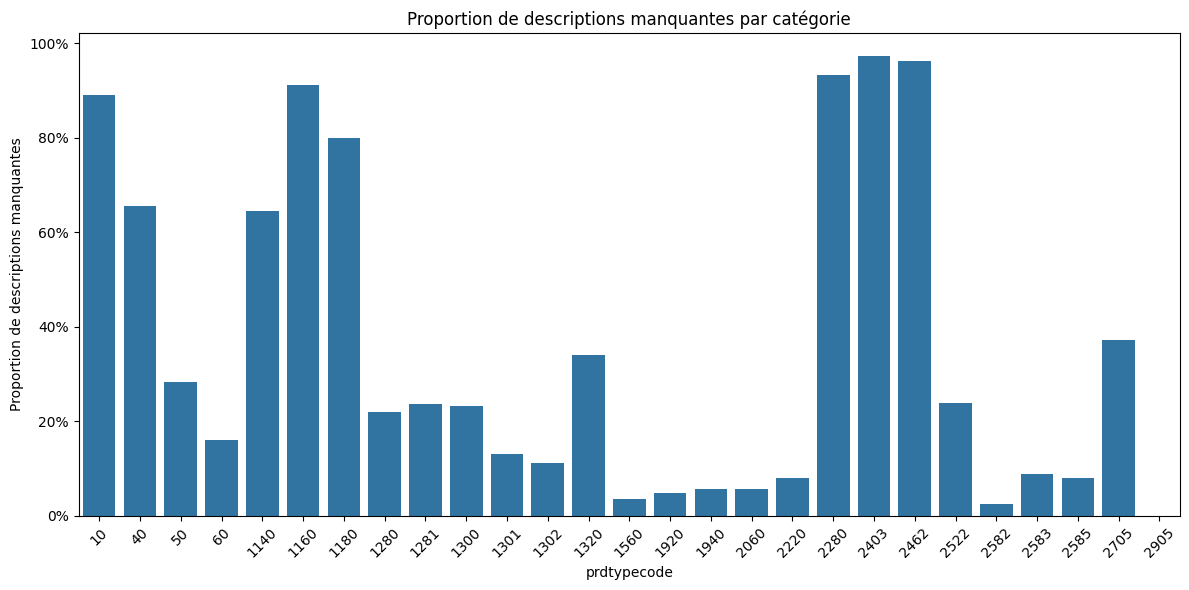

In [60]:
# Calculer la proportion de descriptions manquantes par catégorie ('prdtypecode')
missing_by_cat = (
    df.assign(description_isna=df["description"].isna())  # Ajoute une colonne True/False si la description est NaN
      .groupby("prdtypecode")["description_isna"]        # Regroupe par catégorie de produit
      .mean()                                            # Calcule le taux moyen de NaN (True=1, False=0)
      .reset_index(name="missing_ratio")                 # Convertit le résultat en DataFrame
)

# Trier les catégories par taux de descriptions manquantes
missing_by_cat = missing_by_cat.sort_values("missing_ratio", ascending=False)

# Créer la figure pour le graphique
plt.figure(figsize=(12, 6))

# Créer le graphique en barres
sns.barplot(
    data=missing_by_cat,
    x="prdtypecode",          
    y="missing_ratio"         
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Proportion de descriptions manquantes par catégorie")
plt.xlabel("prdtypecode")
plt.ylabel("Proportion de descriptions manquantes")

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [61]:
# Fonction pour nettoyer et standardiser les données textuelles:
def nettoyer_texte(text):
    if pd.isna(text): return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = ftfy.fix_text(s)                     # Corrige texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime points non numériques
    s = s.replace("/", " ")
    s = s.replace("*", " ")
    s = s.replace(":", " ")
    s = s.replace("-", " ")
    s = s.replace("////", " ")    
    s = reg.sub(r"\s+", " ", s).strip()     # Nettoie espaces et casse
    return s

# Sélectionner la description d'un produit spécifique (index 14), lui appliquer la fonction 'nettoyer_texte',
# puis afficher et comparer le texte original et le texte nettoyé pour vérifier le résultat.
index_to_check = 14
original_text = df.loc[index_to_check, 'description']
cleaned_text = nettoyer_texte(original_text)

print(f"--- Index {index_to_check} [text original] ---")
print(original_text)
print("\n" + "="*40 + "\n")
print(f"--- Index {index_to_check} [text cleaned] ---")
print(cleaned_text)

--- Index 14 [text original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du matelas:<br 

In [62]:
df["designation_clean"] = df["designation"].apply(nettoyer_texte)
df["description_clean"] = df["description"].apply(nettoyer_texte)



In [63]:
df["text"] = (
    df["designation_clean"].fillna("") + " " +
    df["description_clean"].fillna("")
).str.strip()

In [64]:
def get_word_freq(series, top_n=30):
    all_words = []
    for text in series:
        if isinstance(text, str):
            all_words.extend(text.split())
    return Counter(all_words).most_common(top_n)

In [65]:
top_n = 50

freq_before = get_word_freq(df["description"],       top_n=top_n)
freq_after  = get_word_freq(df["description_clean"], top_n=top_n)
freq_text = get_word_freq(df["text"], top_n=top_n)

print("=== Top words BEFORE cleaning ===")
print(freq_before)

print("\n=== Top words AFTER cleaning ===")
print(freq_after)

print("\n=== Top words AFTER cleaning and united ===")
print(freq_text)


=== Top words BEFORE cleaning ===
[('de', 367630), ('et', 144565), ('la', 135983), ('à', 109355), ('pour', 81869), ('en', 77839), (':', 75844), ('le', 69047), ('les', 66652), ('x', 66146), ('des', 51713), ('un', 46007), ('est', 44530), ('une', 41327), ('du', 39303), ('vous', 38690), ('-', 38029), ('avec', 37964), ('/>', 33990), ('votre', 31276), ('1', 31031), ('/', 27014), ('<br', 26820), ('dans', 25435), ('ou', 24796), ('sur', 24404), ('cm', 21891), ('pas', 21689), ('peut', 20083), ('plus', 20017), ('que', 18200), ('au', 17206), ('haute', 15849), ('Le', 15725), ('être', 15259), ('2', 15180), ('*', 14890), ('par', 14730), ('sont', 14053), ('ne', 13912), ('qualité', 13605), ('qui', 13452), ('couleur', 13307), ('piscine', 12656), ('La', 12489), ('a', 12268), ('tout', 11778), ('and', 11091), ('the', 10909), ('/><br', 10872)]

=== Top words AFTER cleaning ===
[('de', 368717), ('et', 144966), ('la', 136535), ('à', 111411), ('pour', 82556), ('en', 78225), ('le', 69861), ('les', 67009), ('x',

In [68]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
standard_stopwords = set(stopwords.words('french'))

def get_word_freq_with_stopwords(series, top_n=50, stopwords_set=None):
    if stopwords_set is None:
        stopwords_set = set()

    all_words = []
    for text in series:
        if isinstance(text, str):
            words=[word for word in text.split() if word not in stopwords_set]
            all_words.extend(words)

    return Counter(all_words).most_common(top_n)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
freq_text_clean = get_word_freq_with_stopwords(
    df["text"], 
    top_n=50, 
    stopwords_set=standard_stopwords
)

print("\n=== Top words AFTER removing NLTK standard stopwords ===")
print(freq_text_clean)

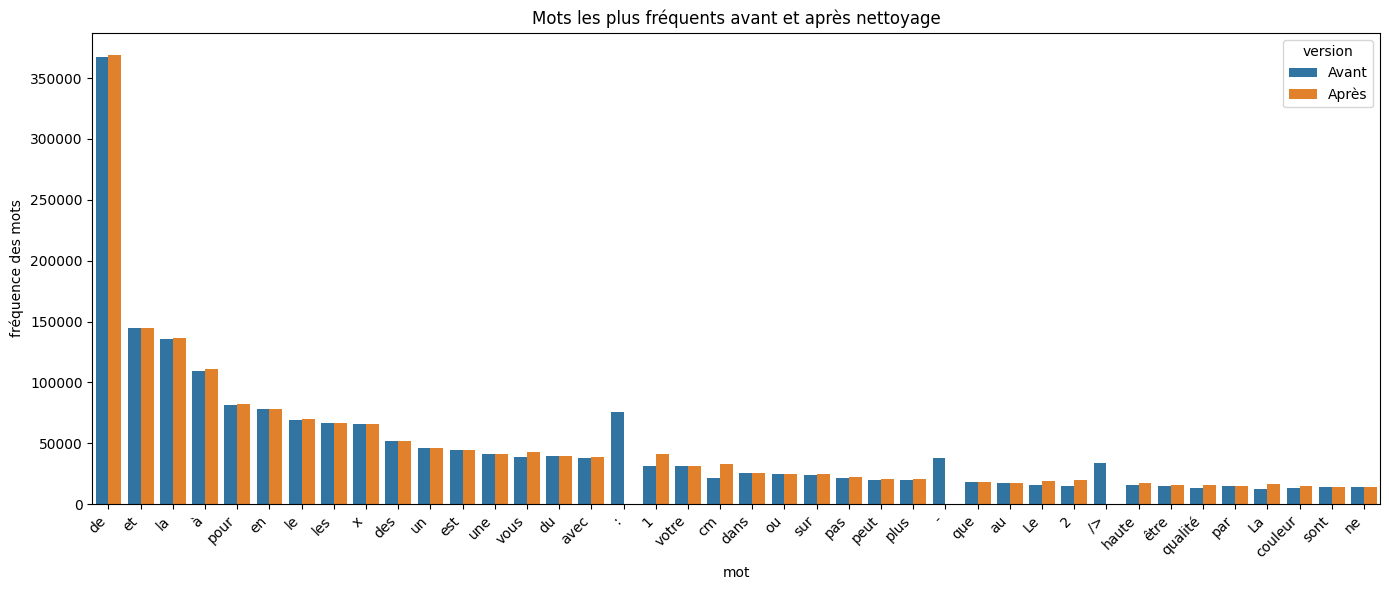

In [69]:
def freq_to_df(freq_list, label):
    df_freq = pd.DataFrame(freq_list, columns=["word", "freq"])
    df_freq["version"] = label
    return df_freq

top_n = 40

df_before = freq_to_df(freq_before, "Avant")
df_after = freq_to_df(freq_after, "Après")

freq_all = pd.concat([df_before, df_after], ignore_index=True)

word_order = (
    freq_all.groupby("word")["freq"]
    .sum()
    .sort_values(ascending=False)
    .index
)[:top_n]

plt.figure(figsize=(14, 6))
sns.barplot(
    data=freq_all,
    x="word",
    y="freq",
    hue="version",
    order=word_order
)

plt.title("Mots les plus fréquents avant et après nettoyage")
plt.xlabel("mot")
plt.ylabel("fréquence des mots")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()